### Import Libraries

In [ ]:
#Pretrained Model InceptionV3 without Top Layer
# !wget https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [1]:

import tensorflow_datasets as tfds
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

----

### Create Model

In [2]:
#Use pretrained model as transfer learning layers
local_weight_file = './pretrained/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

In [3]:
# Load the downloaded pre-trained weights
pre_trained_model.load_weights(local_weight_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [11]:
#Specify input layer model

last_layer = pre_trained_model.get_layer('mixed6')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [13]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.3
x = layers.Dropout(0.3)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

# Append the dense network to the base model
skintypeModel = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
skintypeModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [14]:
# Set the training parameters
skintypeModel.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [15]:
base_dir = '../Dataset/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training dry pictures
train_dry_dir = os.path.join(train_dir, 'dry') 

# Directory with training oily pictures
train_oily_dir = os.path.join(train_dir, 'oily') 

# Directory with validation dry pictures
validation_dry_dir = os.path.join(validation_dir, 'dry') 

# Directory with validation oily pictures
validation_oily_dir = os.path.join(validation_dir, 'oily')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['dry', 'oily'],
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         classes=['dry', 'oily'],
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 380 images belonging to 2 classes.
Found 86 images belonging to 2 classes.


In [16]:
#Defining callback for preventing underfitting and overfitting
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and (logs.get('accuracy') > 0.985 or logs.get('accuracy') < 0.5):
            print("\nCancelling training")
            self.model.stop_training = True

In [17]:
#Train the model
callbacks = myCallback()
history = skintypeModel.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 15,
            callbacks=[callbacks])

Epoch 1/15
19/19 [==============================] - 21s 1s/step - loss: 0.9197 - accuracy: 0.7474 - val_loss: 0.2962 - val_accuracy: 0.8953
Epoch 2/15
19/19 [==============================] - 20s 1s/step - loss: 0.2301 - accuracy: 0.9026 - val_loss: 0.1548 - val_accuracy: 0.9535
Epoch 3/15
19/19 [==============================] - 20s 1s/step - loss: 0.1830 - accuracy: 0.9184 - val_loss: 0.1260 - val_accuracy: 0.9535
Epoch 4/15
19/19 [==============================] - 20s 1s/step - loss: 0.1194 - accuracy: 0.9500 - val_loss: 0.1414 - val_accuracy: 0.9651
Epoch 5/15
19/19 [==============================] - 20s 1s/step - loss: 0.1204 - accuracy: 0.9474 - val_loss: 0.1306 - val_accuracy: 0.9535
Epoch 6/15
19/19 [==============================] - 20s 1s/step - loss: 0.1316 - accuracy: 0.9447 - val_loss: 0.1528 - val_accuracy: 0.9767
Epoch 7/15
19/19 [==============================] - 20s 1s/step - loss: 0.1355 - accuracy: 0.9526 - val_loss: 0.2668 - val_accuracy: 0.9302
Epoch 8/15
19/19 [==

----

### Visualizing Accuracy Plot

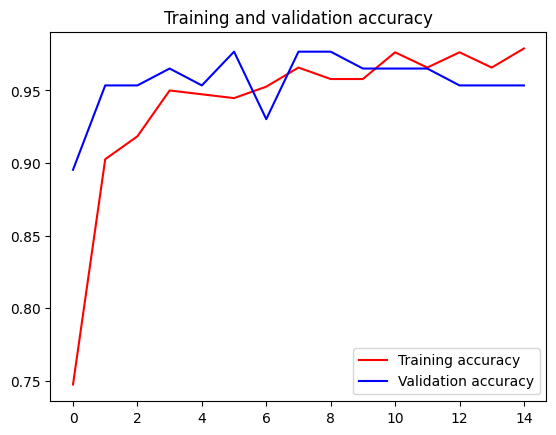

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

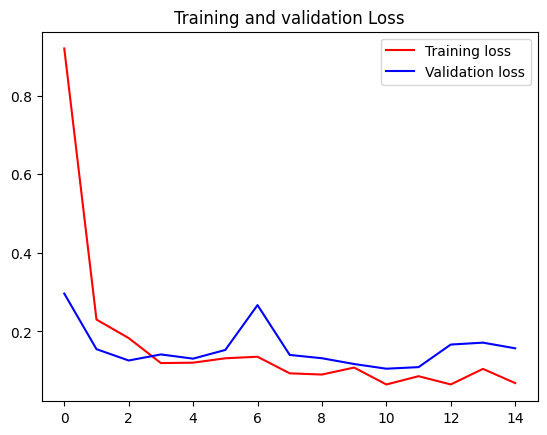

<Figure size 640x480 with 0 Axes>

In [19]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

----

### Try Input Image

In [16]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
# from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

root = tk.Tk()
root.withdraw()
uploaded = filedialog.askopenfilename()
 
# predicting images
path = uploaded
img = load_img(path, target_size=(150, 150))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = skintypeModel.predict(images, batch_size=10)

if classes[0]>0.5:
  print("oily")
else:
  print("dry")
 

1/1 [==============================] - 0s 39ms/step
[0.02168939]
 dry


----

### Convert and Save Model

In [ ]:
import pickle

# Load the previously saved model from a file
with open("scanningmodel.pkl", "rb") as f:
    loaded_models = pickle.load(f)

# Get the existing models from the loaded dictionary
acneModel = loaded_models['model']
rednessModel = loaded_models['model2']

# Create a dictionary with your models
dump = {
    'model': acneModel,
    'model2': rednessModel,
    'model3': skintypeModel, 
}

# Save your models to a file using pickle
with open("scanningmodel.pkl", "wb") as f:
    pickle.dump(dump, f)
